In [ ]:
# Exploratory Data Analysis of DICOM datasets


In [2]:
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import os

plt.rcParams["figure.figsize"] = (10,10)

path = f"samples/DICOM CT study/JohnDoe_CT_series"
slices = [pydicom.dcmread(os.path.join(path, f)) for f in sorted(os.listdir(path))]

len(slices)

136

In [23]:
# check metadata
print(slices[0])
print(f"Pixel Spacing: {slices[0].PixelSpacing}")
print(f"Slice Thickness: {slices[0].SliceThickness}mm")

# Another way to address data elements 
print(f"Pixel Spacing: {slices[0][0x0028,0x0030].value}")

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 256
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.98679204424154357431924637882025380
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.2.8.5.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 2.8.5'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 4.13.0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.9867920442415435743192

In [24]:
# Extract the pixel data
image_data = np.stack([s.pixel_array for s in slices])

print(image_data.shape)

print(image_data.dtype)

(136, 512, 512)
int16


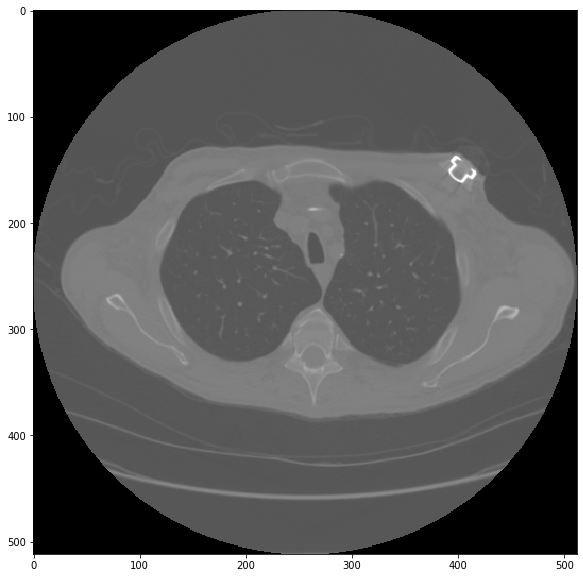

In [25]:
# visualize a slice
img = image_data[115,:,:]
plt.imshow(img,cmap = "gray")

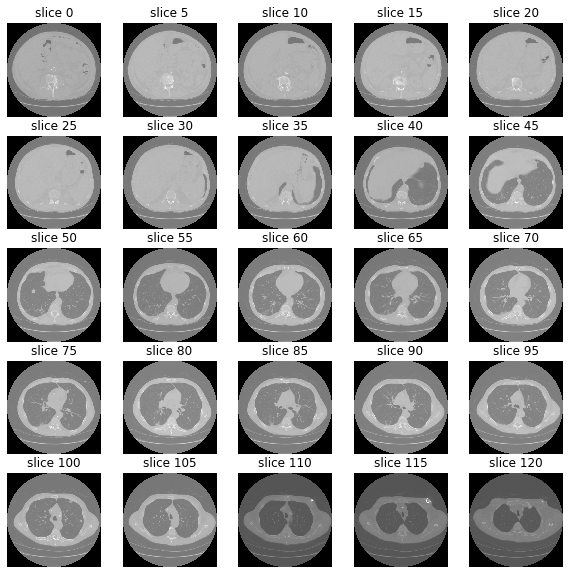

In [26]:
# More slices

fig, ax = plt.subplots(5, 5, figsize=[10,10])

for i in range(25):
    ix = i*int(len(slices)/25)
    ax[int(i/5), int(i%5)].set_title(f"slice {ix}")
    ax[int(i/5), int(i%5)].imshow(image_data[ix, :, :], cmap='gray')
    ax[int(i/5), int(i%5)].axis("off")

plt.show()

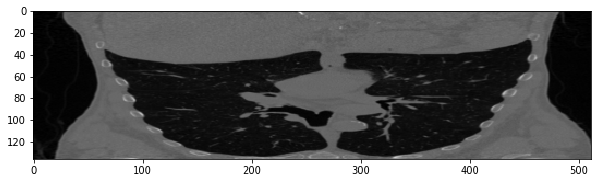

In [27]:
# coronal slice 
img_coronal = image_data[:,250,:]
plt.imshow(img_coronal, cmap="gray")

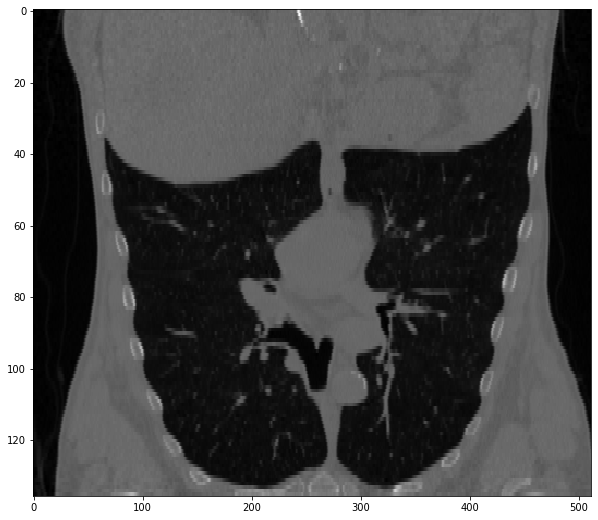

In [28]:
# scale along Z dimension to get proper representation

aspect_ratio = slices[0].SliceThickness/slices[0].PixelSpacing[0]
plt.imshow(img_coronal, cmap="gray", aspect = aspect_ratio)

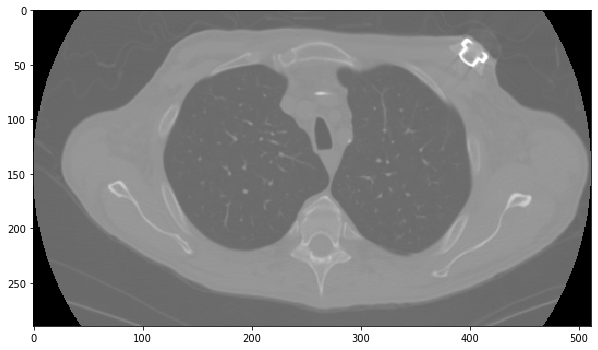

In [29]:
# crop extracted slice 
img_crop = img[110:400,:]
plt.imshow(img_crop,cmap = cm.Greys_r)

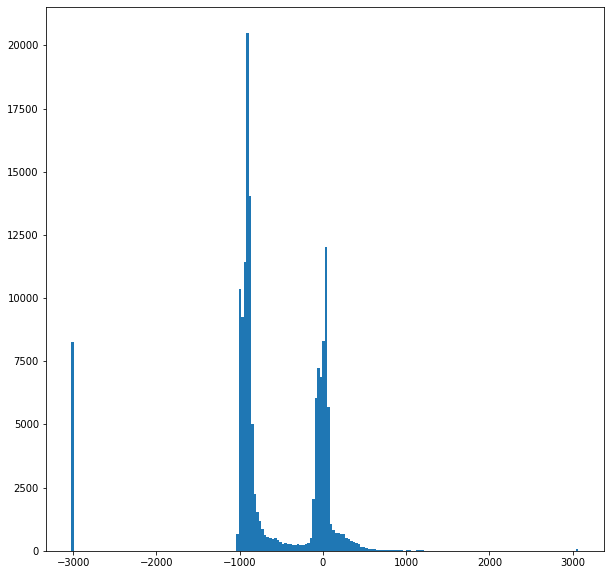

In [30]:
# histogram 
p = img_crop.flatten()
# vals, bins, ignored = plt.hist(p[p>-900], bins = 200)
vals, bins, ignored = plt.hist(p, bins = 200)
plt.show()

In [32]:
print(img_crop.max())
print(img_crop.min())

# The Hounsfield scale; https://en.wikipedia.org/wiki/Hounsfield_scale
np.sort(np.unique(img_crop))

3071
-3024


array([-3024, -1024, -1023, ...,  2972,  3037,  3071], dtype=int16)

-3024 jump to -1024 which wits close to the range of the Hounsfield scale. Possibly -3024 is not a result of reconstruction of the CT sinogram, but rather something was added to the image later.
 CT scanners add "magic" values to pad volumes to rectangles. A large negative value is selected so that it does not overlap with values that would be legitimately present on an HU scale.


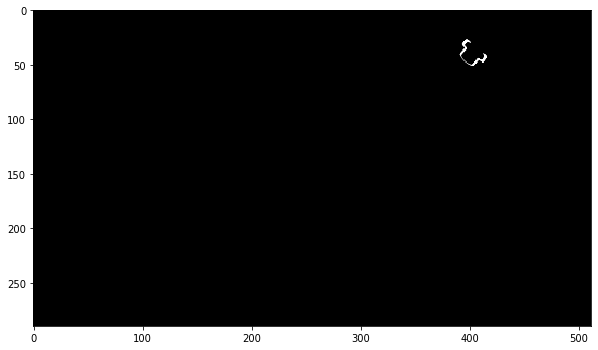

In [33]:
# apply the window
hu_min = 2000
hu_max = 4000

# windowed_img = ma.masked_where((img_crop < hu_min) | (img_crop > hu_max), img_crop)
windowed_img = np.copy(img_crop)
windowed_img[np.where(windowed_img < hu_min)] = hu_min
windowed_img[np.where(windowed_img > hu_max)] = hu_max

# plt.imshow(ma.masked_array(data = img_crop, mask = img_crop > hu_max, fill_value = img_crop.min()).filled(), cmap = cm.Greys_r)
plt.imshow(windowed_img, cmap="gray")

In [34]:
windowed_img.shape

(290, 512)

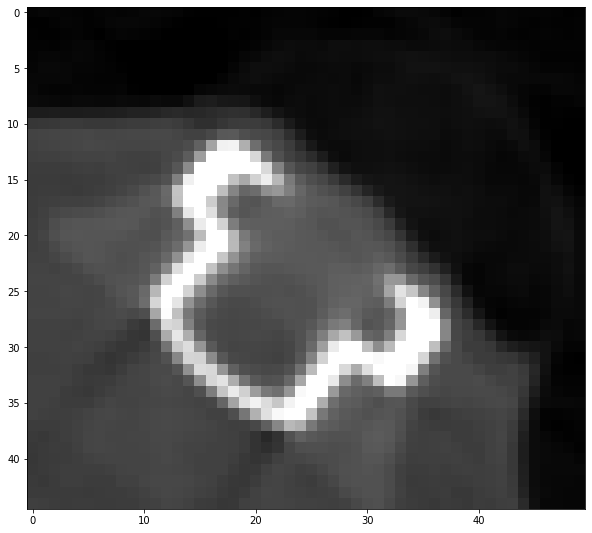

In [35]:
# zoom in 
plt.imshow(img_crop[15:60, 380:430], cmap="gray")

In [20]:
# numpy's Masked Array 

masked = ma.masked_outside(img_crop, hu_min, hu_max)

np.sort(np.unique(img_crop[~masked.mask]))

array([2021, 2029, 2034, 2046, 2060, 2076, 2077, 2090, 2096, 2123, 2126,
       2143, 2150, 2160, 2169, 2212, 2236, 2254, 2317, 2337, 2342, 2350,
       2356, 2376, 2378, 2380, 2383, 2398, 2402, 2403, 2405, 2424, 2430,
       2436, 2456, 2460, 2463, 2496, 2497, 2516, 2529, 2545, 2554, 2570,
       2571, 2608, 2621, 2651, 2663, 2680, 2686, 2733, 2738, 2745, 2746,
       2768, 2784, 2794, 2823, 2837, 2857, 2865, 2873, 2882, 2916, 2946,
       2967, 2968, 2972, 3037, 3071], dtype=int16)

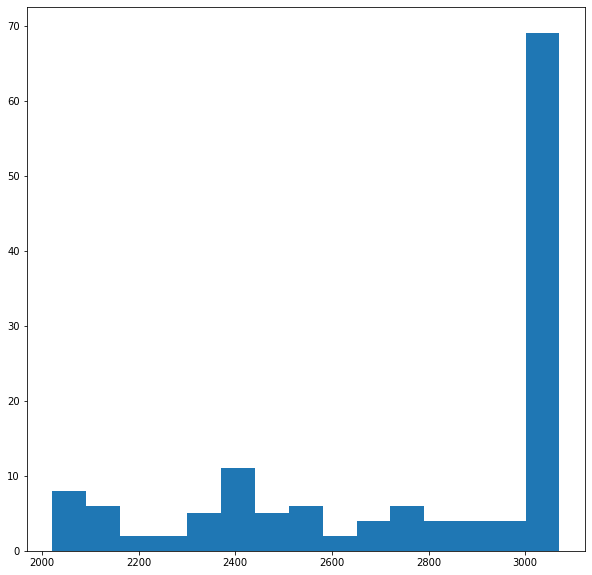

In [36]:
# values in windowed range
_ = plt.hist(masked.flatten(), bins = 15)

plt.show()

synthetic material.chemotherapy port.

Original image's voxel range:

In [22]:
print(f"range: {img_crop.max()-img_crop.min()}")

range: 6095
